# CIS 519 Homework 2: Linear Classifiers

- Handed Out: October 5, 2020
- Due: October 19, 2020 at 11:59pm.

Although the solutions are my own, I consulted with the following people
while working on this homework:
- TODO (if applicable): ...

## Preface

- Feel free to talk to other members of the class in doing the homework. I am more concerned that you learn how to solve the problem than that you demonstrate that you solved it entirely on your own. You should, however, **write down your solution yourself**. Please include here the list of people you consulted with in the course of working on the homework:

- While we encourage discussion within and outside the class, cheating and copying code is strictly not allowed. Copied code will result in the entire assignment being discarded at the very least.

- Please use Piazza if you have questions about the homework. Also, please come to the TAs recitations and to the office hours.

- The homework is due at 11:59 PM on the due date. We will be using Gradescope for collecting the homework assignments. You should have been automatically added to Gradescope. If not, please ask a TA for assistance. Post on Piazza and contact the TAs if you are having technical difficulties in submitting the assignment.

- Here are some resources you will need for this assignment (https://www.seas.upenn.edu/~cis519/fall2020/assets/HW/HW2/hw2-materials.zip)


# Overview

### About Jupyter Notebooks

In this homework assignment, we will use a Jupyter notebook to implement, analyze, and discuss ML classifiers.
Knowing and being comfortable with Jupyter notebooks is a must in every data scientist, ML engineer, researcher, etc. They are widely used in industry and are a standard form of communication in ML by intertwining text and code to "tell a story". There are many resources that can introduce you to Jupyter notebooks (they are pretty easy to understand!), and if you still need help any of the TAs are more than willing to help.

We will be using a local instance of Jupyter instead of Colab. You are of course free to use Colab, but you will need to understand how to hook your Colab instance with Google Drive to upload the datasets and to save images.



### About the Homework

You will experiment with several different linear classifiers and analyze 
their performances in both real and synthetic datasets. The goal is to understand the differences and
similarities between the algorithms and the impact that the dataset characteristics have on the
algorithms' learning behaviors and performances.

In total, there are seven different learning algorithms which you will implement.
Six are variants of the Perceptron algorithm and the seventh is a support vector machine (SVM).
The details of these models is described in Section 1.


In order to evaluate the performances of these models, you will use several different datasets.
The first two datasets are synthetic datasets that have features and labels that were programatically
generated. They were generated using the same script but use different input parameters that produced 
sparse and dense variants. The second two datasets are for the task of named-entity recognition (NER),
identifying the names of people, locations, and organizations within text.
One comes from news text and the other from a corpus of emails.
For these two datasets, you need to implement the feature extraction yourself.
All of the datasets and feature extraction information are described in Section 2.

Finally, you will run two sets of experiments, one on the synthetic data and one on the NER data.
The first set will analyze how the amount of training data impacts model performance.
The second will look at the consequences of having training and testing data that come from different domains.
The details of the experiments are described in Section 3.

### Distribution of Points

The homework has 4 sections for a total of 100 points + 10 extra credit points:
- Section 0: Warmup (5 points)
- Section 1: Linear Classifiers (30 points)
- Section 2: Datasets (0 points, just text)
- Section 3: Experiments (65 points)
    - Synthetic Experiment:
        - Parameter Tuning (10 points)
        - Learning Curves(10 points)
        - Final Test Accuracies (5 points)
        - Discussion Questions (5 points)
        - Noise Experiment (10 points **extra credit**)
    - NER Experiment:
        - Feature Extraction (25 points)
        - Final Test Accuracies (5 points)
        - $F_1$ Discussion Questions (5 points)

# Section 0: Warmup

###### Only For Colab

If you want to complete this homework in Colab, you are more than welcome to.
You will need a little bit more maneuvering since you will need to upload
the files of hw2 to your Google Drive and run the following two cells:

In [1]:
# Uncomment if you want to use Colab for this homework.
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Uncomment if you want to use Colab for this homework.
# %cd /content/drive/My Drive/Colab Notebooks/YOUR_PATH_TO_HW_FOLDER

/content/drive/My Drive/Colab Notebooks


###### Python Version

Python 3.6 or above is required for this homework. Make sure you have it installed.

In [1]:
# Let's check.
import sys
if sys.version_info[:2] < (3, 6):
    raise Exception("You have Python version " + str(sys.version_info))

## Imports and Helper Functions (5 points total)

Let's import useful modules we will need throughout the homework
as well as implement helper functions for our experiment. **Read and remember** what each function is doing, as you will probably need some of them down the line.

In [2]:
# Install necessary libraries for this homework. only need to run once i think
%pip install sklearn
%pip install matplotlib
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import json
import os

import numpy as np
import matplotlib.pylab as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score

DATASETS_PATH = "datasets/"
NER_PATH = os.path.join(DATASETS_PATH, 'ner')
SYNTHETIC_PATH = os.path.join(DATASETS_PATH, 'synthetic')

In [4]:
"""
Helper function that loads a synthetic dataset from the dataset root (e.g. "synthetic/sparse").

You should not need to edit this method.
"""
def load_synthetic_data(dataset_type):

    def load_jsonl(file_path):
        data = []
        with open(file_path, 'r') as f:
            for line in f:
                data.append(json.loads(line))
        return data

    def load_txt(file_path):
        data = []
        with open(file_path, 'r') as f:
            for line in f:
                data.append(int(line.strip()))
        return data

    def convert_to_sparse(X):
        sparse = []
        for x in X:
            data = {}
            for i, value in enumerate(x):
                if value != 0:
                    data[str(i)] = value
            sparse.append(data)
        return sparse

    path = os.path.join(SYNTHETIC_PATH, dataset_type)
    
    X_train = load_jsonl(os.path.join(path, 'train.X'))
    X_dev = load_jsonl(os.path.join(path, 'dev.X'))
    X_test = load_jsonl(os.path.join(path, 'test.X'))

    num_features = len(X_train[0])
    features = [str(i) for i in range(num_features)]

    X_train = convert_to_sparse(X_train)
    X_dev = convert_to_sparse(X_dev)
    X_test = convert_to_sparse(X_test)

    y_train = load_txt(os.path.join(path, 'train.y'))
    y_dev = load_txt(os.path.join(path, 'dev.y'))
    y_test = load_txt(os.path.join(path, 'test.y'))

    return X_train, y_train, X_dev, y_dev, X_test, y_test, features

In [5]:
"""
Helper function that loads the NER data from a path (e.g. "ner/conll/train"). 

You should not need to edit this method.
"""
def load_ner_data(dataset=None, dataset_type=None):
    # List of tuples for each sentence
    data = []
    path = os.path.join(os.path.join(NER_PATH, dataset), dataset_type)
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'r') as file:
            sentence = []
            for line in file:
                if line == '\n':
                    data.append(sentence)
                    sentence = []
                else:
                    sentence.append(tuple(line.split()))
    return data

In [6]:
"""
A helper function that plots the relationship between number of examples
and accuracies for all the models.

You should not need to edit this method.
"""
def plot_learning_curves(
    perceptron_accs,
    winnow_accs,
    adagrad_accs,
    avg_perceptron_accs,
    avg_winnow_accs,
    avg_adagrad_accs,
    svm_accs
):
    """
    This function will plot the learning curve for the 7 different models.
    Pass the accuracies as lists of length 11 where each item corresponds
    to a point on the learning curve.
    """
    
    accuracies = [
        ('perceptron', perceptron_accs),
        ('winnow', winnow_accs),
        ('adagrad', adagrad_accs),
        ('avg-perceptron', avg_perceptron_accs),
        ('avg-winnow', avg_winnow_accs),
        ('avg-adagrad', avg_adagrad_accs),
        ('svm', svm_accs)
    ]
    
    x = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000]
    plt.figure()
    f, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w')
    
    for label, acc_list in accuracies:
        assert len(acc_list) == 11
        ax.plot(x, acc_list, label=label)
        ax2.plot(x, acc_list, label=label)
        
    ax.set_xlim(0, 5500)
    ax2.set_xlim(9500, 10000)
    ax2.set_xticks([10000])
    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax.tick_params(labelright='off')
    ax2.yaxis.tick_right()
    ax2.legend()
    plt.show()

### F1 Score (5 points)

For some part of the homework, you will use the F1 score instead of accuracy to evaluate how well a model does. The F1 score is computed as the harmonic mean of the precision and recall of the classifier. Precision measures the number of correctly identified positive results by the total number of positive results. Recall, on the other hand, measures the number of correctly identified positive results divided by the number of all samples that should have been identified as positive. More formally, we have that

$$
\begin{align}
\text{Precision} &= \frac{TP}{TP + FP} \\
\text{Recall} &= \frac{TP}{TP + FN}
\end{align}
$$

where $TP$ is the number of true positives, $FP$ false positives and $FN$ false negatives. Combining these two we define F1 as

$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

You now need to implement the calculation of F1 yourself using the provided function header. It will be unit tested on Gradescope.

In [7]:
def calculate_f1(y_gold, y_model):
    """
    TODO: MODIFY 
    
    Computes the F1 of the model predictions using the
    gold labels. Each of y_gold and y_model are lists with
    labels 1 or -1. The function should return the F1
    score as a number between 0 and 1.
    """
    import numpy as np

    diff = np.zeros(len(y_gold))
    for i in range(len(y_gold)):
        diff[i] = y_gold[i] - y_model[i]
    TP = 0
    FP = 0
    FN = 0
    
    for i in range(len(diff)):
        if diff[i] == 0 and y_gold[i] == 1:
            TP += 1
        if diff[i] > 0:
            FN += 1
        if diff[i] < 0:
            FP += 1
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)
    
    return F1

Looking at the formula for the F1 score, what is the highest and lowest possible value?

In [8]:
def highest_and_lowest_f1_score():
    """
    TODO: MODIFY
    
    Return the highest and lowest possible F1 score
    (ie one line solution returning the theoretical max and min)
    """
    
    maxscore = 1
    minscore = 0
    
    return maxscore, minscore

# Section 1. Linear Classifiers (30 points total)

This section details the seven different algorithms that you will use in the experiments. For each of the algorithms, we describe the initialization you should use to start training and the different parameter settings that you should use for the experiment on the synthetic datasets. Each of the update functions for the Perceptron, Winnow, and Perceptron with AdaGrad will be unittested on Gradescope, so please do not edit the function definitions.

### 1.1 Base Classifier

In [9]:
class Classifier(object):
    """
    DO NOT MODIFY

    The Classifier class is the base class for all of the Perceptron-based
    algorithms. Your class should override the "process_example" and
    "predict_single" functions. Further, the averaged models should
    override the "finalize" method, where the final parameter values
    should be calculated. 
    
    You should not need to edit this class any further.
    """
    
    ITERATIONS = 10
    
    def train(self, X, y):
        for iteration in range(self.ITERATIONS):
            for x_i, y_i in zip(X, y):
                self.process_example(x_i, y_i)
        self.finalize()

    def process_example(self, x, y):
        """
        Makes a prediction using the current parameter values for
        the features x and potentially updates the parameters based
        on the gradient. Note "x" is a dictionary which maps from the feature
        name to the feature value and y is either 1 or -1.
        """
        raise NotImplementedError

    def finalize(self):
        """Calculates the final parameter values for the averaged models."""
        pass

    def predict(self, X):
        """
        Predicts labels for all of the input examples. You should not need
        to override this method.
        """
        return [self.predict_single(x) for x in X]

    def predict_single(self, x):
        """
        Predicts a label, 1 or -1, for the input example. "x" is a dictionary
        which maps from the feature name to the feature value.
        """
        raise NotImplementedError

### 1.2 Basic Perceptron (2 points)

We do this classifier for you, so enjoy the two free points and pay attention to the techniques and code written.

#### 1.2.1 Description

This is the basic version of the Perceptron Algorithm.
    In this version, an update will be performed on the example $(\textbf{x}, y)$ if $y(\mathbf{w}^\intercal \mathbf{x} + \theta) \leq 0$. The Perceptron needs to learn both the bias term $\theta$ and the weight vector $\mathbf{w}$ parameters.
When the Perceptron makes a mistake on the example $(\textbf{x}, y)$, both $\mathbf{w}$ and $\theta$ need to be updated using the following update equations:
$$
\begin{align*}
    \mathbf{w}^\textrm{new} &\gets \mathbf{w} + \eta \cdot y \cdot \mathbf{x} \\
    \theta^\textrm{new} &\gets \theta + \eta \cdot y
\end{align*}
$$
where $\eta$ is the learning rate.

#### 1.2.2 Hyperparameters

We set $\eta$ to 1, so there are no hyperparameters to tune. 

Note: If we assume that the order of the examples presented to the algorithm is fixed, we initialize $\mathbf{w} = \mathbf{0}$ and $\theta = 0$, and train both together, then the learning rate $\eta$ does not have any effect.
        In fact you can show that, if $\mathbf{w}_1$ and $\theta_1$ are the outputs of the Perceptron algorithm with learning rate $\eta_1$, then $\mathbf{w}_1/\eta_1$ and $\theta_1/\eta_1$ will be the result of the Perceptron with learning rate 1 (note that these two hyperplanes give identical predictions).

#### 1.2.3 Initialization

$\mathbf{w} = [0, 0, \dots, 0]$ and $\theta = 0$.

In [10]:
class Perceptron(Classifier):
    """
    DO NOT MODIFY THIS CELL

    The Perceptron model. Note how we are subclassing `Classifier`.
    """
    
    def __init__(self, features):
        """
        Initializes the parameters for the Perceptron model. "features"
        is a list of all of the features of the model where each is
        represented by a string.
        """
        
        # NOTE: Do not change the names of these 3 data members because
        # they are used in the unit tests
        self.eta = 1
        self.theta = 0
        self.w = {feature: 0.0 for feature in features}

    def process_example(self, x, y):
        y_pred = self.predict_single(x)
        if y != y_pred:
            for feature, value in x.items():
                self.w[feature] += self.eta * y * value
            self.theta += self.eta * y

    def predict_single(self, x):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        if score <= 0:
            return -1
        return 1

For the rest of the Perceptron-based algorithms, you will have to implement the corresponding class like we have done for `Perceptron`.
Use the `Perceptron` class as a guide for how to implement the functions.

### 1.3 Winnow (5 points)

#### 1.3.1 Description
The Winnow algorithm is a variant of the Perceptron algorithm with multiplicative updates. Since the algorithm requires that the target function is monotonic, you will only use it on the synthetic datasets.

The Winnow algorithm only learns parameters $\mathbf{w}$.
We will fix $\theta = -n$, where $n$ is the number of features.
When the Winnow algorithm makes a mistake on the example $(\textbf{x}, y)$, the parameters are updated with the following equation:
$$
\begin{equation}
    w^\textrm{new}_i \gets w_i \cdot \alpha^{y \cdot x_i}
\end{equation}
$$
where $w_i$ and $x_i$ are the $i$th components of the corresponding vectors.
Here, $\alpha$ is a promotion/demotion hyperparameter.

#### 1.3.2 Hyperparameters

For the experiment, choose $\alpha \in \{1.1, 1.01, 1.005, 1.0005, 1.0001\}$.

#### 1.3.3 Initialization

$\mathbf{w} = [1, 1, \dots, 1]$ and $\theta = -n$ (constant).

In [11]:
class Winnow(Classifier):
    def __init__(self, alpha, features):
        # DO NOT change the names of these 3 data members because
        # they are used in the unit tests
        self.alpha = alpha
        self.w = {feature: 1.0 for feature in features}
        self.theta = -len(features)
        
    def process_example(self, x, y):
        """ TODO: IMPLEMENT"""
        
        y_pred = self.predict_single(x)
        if y != y_pred:
            for feature, value in x.items():
                self.w[feature] = self.w[feature] * pow(self.alpha,y*value)
        

    def predict_single(self, x):
        """ TODO: IMPLEMENT"""
        
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        
        if score <= 0:
            return -1
        return 1


### 1.4 AdaGrad (10 points)

#### 1.4.1 Description
AdaGrad is a variant of the Perceptron algorithm that adapts the learning rate for each parameter based on historical information.
    The idea is that frequently changing features get smaller learning rates and stable features higher ones.

To derive the update equations for this model, we first need to start with the loss function.
Instead of using the hinge loss with the elbow at 0 (like the basic Perceptron does), we will instead use the standard hinge loss with the elbow at 1:

$$
\begin{equation}
    \mathcal{L}(\mathbf{x}, y, \mathbf{w}, \theta) = \max\left\{0, 1 - y(\mathbf{w}^\intercal \mathbf{x} + \theta)\right\}
\end{equation}
$$

Then, by taking the partial derivative of $\mathcal{L}$ with respect to $\mathbf{w}$ and $\theta$, we can derive the respective graidents (make sure you understand how you could derive these gradients on your own):

$$
\begin{align}
    \frac{\partial\mathcal{L}}{\partial\mathbf{w}} &=
        \begin{cases}
        \mathbf{0} & \text{if $y(\mathbf{w}^\intercal \mathbf{x} + \theta) > 1$} \\
        -y\cdot \mathbf{x} & \textrm{otherwise}
        \end{cases} \\
    \frac{\partial\mathcal{L}}{\partial\theta} &=
        \begin{cases}
            0 & \text{if $y(\mathbf{w}^\intercal \mathbf{x} + \theta) > 1$} \\
            -y & \textrm{otherwise}
        \end{cases}
\end{align}
$$

Then for each parameter, we will keep track of the sum of the parameters' squared gradients.
In the following equations, the $k$ superscript refers to the $k$th non-zero gradient (i.e., the $k$th weight vector/misclassified example) and $t$ is the number of mistakes seen thus far.

$$
\begin{align}
    G^t_j &= \sum_{k=1}^t \left(\frac{\partial \mathcal{L}}{\partial w^k_j}\right)^2 \\
    H^t &= \sum_{k=1}^t \left(\frac{\partial \mathcal{L}}{\partial \theta^k}\right)^2
\end{align}
$$

For example, on the 3rd mistake ($t = 3$), $G^3_j$ is the sum of the squares of the first three non-zero gradients ($\left(\frac{\partial \mathcal{L}}{\partial w^1_j}\right)^2$, $\left(\frac{\partial \mathcal{L}}{\partial w^2_j}\right)^2$, and $\left(\frac{\partial \mathcal{L}}{\partial w^3_j}\right)^2$).
Then $\mathbf{G}^3$ is used to calculate the 4th value of the weight vector as follows.
On example $(\mathbf{x}, y)$, if $y(\mathbf{w}^\intercal \mathbf{x} + \theta) \leq 1$, then the parameters are updated with the following equations:

$$
\begin{align}
    \mathbf{w}^{t+1} &\gets \mathbf{w}^t + \eta \cdot \frac{y \cdot \mathbf{x}}{\sqrt{\mathbf{G}^t}} \\
    \theta^{t+1} &\gets \theta^t + \eta \frac{y}{\sqrt{H^t}}
\end{align}
$$

Note that, although we use the hinge loss with the elbow at 1 for training, you still make the prediction based on whether or not $y(\mathbf{w}^\intercal \mathbf{x} + \theta) \leq 0$ during testing.

#### 1.4.2 Hyperparameters

For the experiment, choose $\eta \in \{1.5, 0.25, 0.03, 0.005, 0.001\}$

#### 1.4.3 Initialization

$\mathbf{w} = [0, 0, \dots, 0]$ and $\theta = 0$.

In [12]:
class AdaGrad(Classifier):
    def __init__(self, eta, features):
        # DO NOT change the names of these 3 data members because
        # they are used in the unit tests
        self.eta = eta
        self.w = {feature: 0.0 for feature in features}
        self.theta = 0
        self.G = {feature: 1e-5 for feature in features}  # 1e-5 prevents divide by 0 problems
        self.H = 0
        
    def process_example(self, x, y):
        """ TODO: IMPLEMENT"""
        import numpy as np
        
        y_pred = self.predict_single(x)
        dotpro = 0
        
        if y != y_pred:
            
#             calculate dot product
            for feature, value in x.items():
                dotpro += self.w[feature] * value
                
#             update w
            for feature, value in x.items():
                if(y * (dotpro + self.theta) > 1):
                    dldw = 0                   
                else:
                    dldw = -y * value
                self.G[feature] += dldw ** 2
                self.w[feature] += self.eta * y * value / np.sqrt(self.G[feature])
                
#             update theta        
            if(y * (dotpro + self.theta) > 1):
                dldtheta = 0
            else:
                dldtheta = -y
            self.H += dldtheta ** 2
            self.theta += self.eta * y / np.sqrt(self.H)  
        

    def predict_single(self, x):
        """ TODO: IMPLEMENT"""

        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        
        if score <= 0:
            return -1
        return 1
        

### 1.5 Averaged Models (15 points)

You will also implement the averaged version of the previous three algorithms.

During the course of training, each of the above algorithms will have $K + 1$ different parameter settings for the $K$ different updates it will make during training.
The regular implementation of these algorithms uses the parameter values after the $K$th update as the final ones.
Instead, the averaged version use the weighted average of the $K + 1$ parameter values as the final parameter values.
Let $m_k$ denote the number of correctly classified examples by the $k$th parameter values and $M$ the total number of correctly classified examples.
The final parameter values are

$$
\begin{align}
    M &= \sum_{k=1}^{K+1} m_k \\
    \mathbf{w} &\gets \frac{1}{M} \sum_{k=1}^{K+1} m_k \cdot \mathbf{w}^k \\
    \theta &\gets \frac{1}{M} \sum_{k=1}^{K+1} m_k \cdot \theta^k \\
\end{align}
$$

For each of the averaged versions of Perceptron, Winnow, and AdaGrad, use the same hyperparameters and initialization as before.

#### 1.5.1 Implementation Note
Implementing the averaged variants of these algorithms can be tricky.
    While the final parameter values are based on the sum of $K$ different vectors, there is no need to maintain *all* of these parameters.
    Instead, you should implement these algorithms by keeping only two vectors, one which maintains the cumulative sum and the current one.

Additionally, there are two ways of keeping track of these two vectors.
One is more straightforward but prohibitively slow.
The second requires some algebra to derive but is significantly faster to run.
Try to analyze how the final weight vector is a function of the intermediate updates and their corresponding weights.
It should take less than a minute or two for ten iterations for any of the averaged algorithms.
**You need to think about how to efficiently implement the averaged algorithms yourself.**

Further, the implementation for Winnow is slightly more complicated than the other two, so if you consistently have low accuracy for the averaged Winnow, take a closer look at the derivation.

In [162]:
class AveragedPerceptron(Classifier):
    def __init__(self, features):
        self.eta = 1
        self.w = {feature: 0.0 for feature in features}
        self.theta = 0
        """TODO: You will need to add data members here"""
        self.M = 0
        self.lastM = 0
        self.weightedW = {feature: 1.0 for feature in features}
        self.weightedT = 0     
        
    def process_example(self, x, y):
        """ TODO: IMPLEMENT"""
        y_pred = self.predict_single(x)
        if y != y_pred:
            
#             update sum of mk*wk and mk*thetak
            for feature in self.weightedW:
                self.weightedW[feature] += (self.M - self.lastM) * self.w[feature]
            self.weightedT += (self.M - self.lastM) * self.theta
            
#             update weights
            for feature, value in x.items():
                self.w[feature] += self.eta * y * value
            self.theta += self.eta * y
            
#             reset lastM
#             self.M += 1
            self.lastM = self.M
            
        else:
            self.M += 1
        
    def predict_single(self, x):
        """ TODO: IMPLEMENT"""
        
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        if score <= 0:
            return -1
        return 1  
        
    def finalize(self):
        """ TODO: IMPLEMENT"""
        self.M +=1
        for feature in self.weightedW:
            self.w[feature] = 1/self.M * self.weightedW[feature]
        self.theta = 1/self.M * self.weightedT
        

In [53]:
# test the averaged perceptron model

X_train, y_train, X_dev, y_dev, X_test, y_test, features = load_synthetic_data('dense')

AvgPerceptron = AveragedPerceptron(features)
iteration = 10

for iter in range(iteration):
    for i in range(len(X_train)):
        AvgPerceptron.process_example(X_train[i],y_train[i])
AvgPerceptron.finalize()

count = 0
for i in range(len(X_dev)):
    x = X_dev[i]
    y = AvgPerceptron.predict_single(x)
    if y_dev[i] == y:
        count += 1
print(count/len(X_dev))

0.9445


In [161]:
class AveragedWinnow(Classifier):
    def __init__(self, alpha, features):
        self.alpha = alpha
        self.w = {feature: 1.0 for feature in features}
        self.theta = -len(features)
        """TODO: You will need to add data members here"""
        self.M = 0
        self.lastM = 0
        self.weightedW = {feature: 1.0 for feature in features}

        
    def process_example(self, x, y):
        """ TODO: IMPLEMENT"""
              
        y_pred = self.predict_single(x)
        if y != y_pred:
            for feature, value in x.items():
                self.w[feature] = self.w[feature] * pow(self.alpha,y*value)
                
            for feature in self.weightedW:
                self.weightedW[feature] += (self.M - self.lastM) * self.w[feature]
            
#             self.M += 1
            self.lastM = self.M
        else:
            self.M +=1


    def predict_single(self, x):
        """ TODO: IMPLEMENT"""
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        
        if score <= 0:
            return -1
        return 1
        
    def finalize(self):
        """ TODO: IMPLEMENT"""
        self.M += 1
        for feature in self.weightedW:
            self.w[feature] = 1/self.M * self.weightedW[feature]        
        

In [145]:
# test the averaged Winnow model

X_train, y_train, X_dev, y_dev, X_test, y_test, features = load_synthetic_data('sparse')

iteration = 10
alpha = 1.1
AvgWinnow = AveragedWinnow(alpha,features)
AvgWinnow.train(X_train,y_train)

# AvgWinnow = Winnow(alpha,features)
# AvgWinnow.train(X_train,y_train)

count = 0
for i in range(len(X_dev)):
    x = X_dev[i]
    y = AvgWinnow.predict_single(x)
    if y_dev[i] == y:
        count += 1
print(count/len(X_dev))

0.939


In [160]:
class AveragedAdaGrad(Classifier):
    def __init__(self, eta, features):
        self.eta = eta
        self.w = {feature: 0.0 for feature in features}
        self.theta = 0
        self.G = {feature: 1e-5 for feature in features}
        self.H = 0
        """TODO: You will need to add data members here"""
        self.M = 0
        self.lastM = 0
        self.weightedW = {feature: 1.0 for feature in features}
        self.weightedT = 0
        
    def process_example(self, x, y):
        """ TODO: IMPLEMENT"""
        import numpy as np
        
        y_pred = self.predict_single(x)
        dotpro = 0
        
        if y != y_pred:
            
            for feature in self.weightedW:
                self.weightedW[feature] += (self.M - self.lastM) * self.w[feature]
            self.weightedT += (self.M - self.lastM) * self.theta
            
#             calculate dot product
            for feature, value in x.items():
                dotpro += self.w[feature] * value
                
#             update w
            for feature, value in x.items():
                if(y * (dotpro + self.theta) > 1):
                    dldw = 0                   
                else:
                    dldw = -y * value
                self.G[feature] += dldw ** 2
                self.w[feature] += self.eta * y * value / np.sqrt(self.G[feature])
                
#             update theta        
            if(y * (dotpro + self.theta) > 1):
                dldtheta = 0
            else:
                dldtheta = -y
            self.H += dldtheta ** 2
            self.theta += self.eta * y / np.sqrt(self.H)  
            
            self.lastM = self.M
            
        else:
            self.M += 1
        

    def predict_single(self, x):
        """ TODO: IMPLEMENT"""

        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        
        if score <= 0:
            return -1
        return 1
        
    def finalize(self):
        """ TODO: IMPLEMENT"""
        self.M += 1
        for feature in self.weightedW:
            self.w[feature] = 1/self.M * self.weightedW[feature]
        self.theta = 1/self.M * self.weightedT

In [135]:
# test the averaged Adagrad model

X_train, y_train, X_dev, y_dev, X_test, y_test, features = load_synthetic_data('dense')

# 𝜂∈{1.5,0.25,0.03,0.005,0.001}

eta = 1.5
AvgAdaGrad = AveragedAdaGrad(eta,features)
AvgAdaGrad.train(X_train,y_train)
# OrigAdaGrad = AdaGrad(eta,features)
# OrigAdaGrad.train(X_train,y_train)

count = 0
for i in range(len(X_dev)):
    x = X_dev[i]
    y = AvgAdaGrad.predict_single(x)
    if y_dev[i] == y:
        count += 1
print(count/len(X_dev))

0.9445


### 1.6 Support Vector Machines

Although we have not yet covered SVMs in class, you can still train them using the `sklearn` library.
We will use a soft margin SVM for non-linearly separable data.
You should use the `sklearn` implementation as follows:
```
from sklearn.svm import LinearSVC
classifier = LinearSVC(loss='hinge')
classifier.fit(X, y)
```

`sklearn` requires a different feature representation than what we use for the Perceptron models.
The provided Python template code demonstrates how to convert to the require representation.


Given training samples $S = \{(\mathbf{x}^1, y^1), (\mathbf{x}^2, y^2), \dots, (\mathbf{x}^m, y^m)\}$, the objective for the SVM is the following:

$$
\begin{equation}
    \min_{\mathbf{w}, b, \boldsymbol{\xi}} \frac{1}{2} \vert\vert \mathbf{w}\vert\vert^2_2 + C \sum_{i=1}^m \xi_i
\end{equation}
$$

subject to the following constraints:

$$
\begin{align}
    y^i(\mathbf{w}^\intercal \mathbf{x}^i + b) \geq 1 - \xi_i \;\;&\textrm{for } i = 1, 2, \dots, m \\
    \xi_i \geq 0 \;\;& \textrm{for } i = 1, 2, \dots, m
\end{align}
$$


In [169]:
class SVMClassifier(Classifier):
    
    def __init__(self):
        from sklearn.svm import LinearSVC
        self.local_classifier = LinearSVC(loss = 'hinge')
        self.vectorizer = DictVectorizer()
        
    def trainSVM(self,X_train,y_train):
        X_train_dict = self.vectorizer.fit_transform(X_train)
        self.local_classifier.fit(X_train_dict,y_train)
    
    def testSVM(self,X_test,y_test):
        X_test_dict = self.vectorizer.transform(X_test)
        return self.local_classifier.score(X_test_dict,y_test)

In [96]:
"""TODO: Create an SVM classifier"""
X_train, y_train, X_dev, y_dev, X_test, y_test, features = load_synthetic_data('dense')

# This is how you convert from the way we represent features in the
# Perceptron code to how you need to represent features for the SVM.
# You can then train with (X_train_dict, y_train) and test with
# (X_conll_test_dict, y_conll_test) and (X_enron_test_dict, y_enron_test)
vectorizer = DictVectorizer()
X_train_dict = vectorizer.fit_transform(X_train)
X_test_dict = vectorizer.transform(X_test)

    
from sklearn.svm import LinearSVC
classifier = LinearSVC(loss = 'hinge')
classifier.fit(X_train_dict,y_train)
classifier.score(X_test_dict,y_test)

0.9405

# Section 2. Datasets

In this section, we describe the synthetic and NER datasets that you will use for your experiments.
For the NER datasets, there is also an explanation for the features which you need to extract from the data.

### 2.1 Synthetic Data

#### 2.1.1 Introduction

The synthetic datasets have features and labels which are automatically generated from a python script.
Each instance will have $n$ binary features and are labeled according to a $l$-of-$m$-of-$n$ Boolean function.
Specifically, there is a set of $m$ features such that an example if positive if and only if at least $l$ of these $m$ features are active.
The set of $m$ features is the same for the dataset (i.e., it is not a separate set of $m$ features for each individual instance).

We provide two versions of the synthetic dataset called sparse and dense.
For both datasets, we set $l = 10$ and $m=20$.
We set $n = 200$ for the sparse data and $n = 40$ for the dense data.
Additionally, we add noise to the data as follows:
With probability $0.05$ the label assigned by the function is changed and with probability $0.001$ each feature value is changed.
Consequently, the data is not linearly separable.

We have provided you with three data splits for both sparse and dense with 10,000 training, 2,000 development, and 2,000 testing examples.
Section 3 describes the experiments that you need to run on these datasets.

#### 2.1.2 Feature Representation

The features of the synthetic data provided are vectors of 0s and 1s.
Storing these large matrices requires lots of memory so we use a sparse representation that stores them as dictionaries instead.
For example, the vector $[0,1,0,0,0,1]$ can be stored as `{"x2": 1,"x6": 1}` (using 1-based indexing).
We have provided you with the code for parsing and converting the data to this format.
You can use these for the all algorithms you develop except the SVM.
Since you will be using the implementation of SVM from sklearn, you will need to provide a vector to it. You can use `sklearn.feature_extraction.DictVectorizer` for converting feature-value dictionaries to vectors.

### 2.2 NER Data

In addition to the synthetic data, we have provided you two datasets for the task of named-entity recognition (NER).
The goal is to identify whether strings in text represent names of people, organizations, or locations.
An example instance looks like the following:

```
    [PER Wolff] , currently a journalist in [LOC Argentina] , played with
    [PER del Bosque] in the final years of the seventies in
    [ORG Real Madrid] .
```

In this problem, we will simplify the task to identifying whether a string is named entity or not (that is, you don't have to say which type of entity it is).
For each token in the input, we will use the tag $\texttt{I}$ to denote that token is an entity and $\texttt{O}$ otherwise.
For example, the full tagging for the above instace is as follows:

```
    [I Wolff] [O ,] [O currently] [a] [O journalist] [O in] [I Argentina]
    [O ,] [O played] [O with] [I del] [I Bosque] [O in] [O the] [O final]
    [O years] [O of] [O the] [O seventies] [O in] [I Real] [I Madrid] .
```

Given a sentence $S = w_1, w_2, \dots, w_n$, you need to predict the `I`, `O` tag for each word in the sentence.
That is, you will produce the sequence $Y = y_1, y_2, \dots, y_n$ where $y_i \in$ {`I`, `O`}.

#### 2.2.1 Datasets: CoNLL and Enron

We have provided two datasets, the CoNLL dataset which is text from news articles, and Enron, a corpus of emails.
The files contain one word and one tag per line.
For CoNLL, there are training, development, and testing files, whereas Enron only has a test dataset.
There are 14,987 training sentences (204,567 words), 336 development sentences (3,779 words), and 303 testing sentences (3,880 words) in CoNLL.
For Enron there are 368 sentences (11,852 words).

**Please note that the CoNLL dataset is available only for the purposes of this assignment.
It is copyrighted, and you are granted access because you are a Penn student, but please delete it when you are done with the homework.**

#### 2.2.2 Feature Extraction

The NER data is provided as raw text, and you are required to extract features for the classifier.
In this assignment, we will only consider binary features based on the context of the word that is supposed to be tagged.

Assume that there are $V$ unique words in the dataset and each word has been assigned a unique ID which is a number $\{1, 2, \dots, V\}$.
Further, $w_{-k}$ and $w_{+k}$ indicate the $k$th word before and after the target word.
The feature templates that you should use to generate features are as follows:

| Template             | Number of Features |
|----------------------|--------------------|
| $w_{-3}$             | $V$                |
| $w_{-2}$             | $V$                |
| $w_{-1}$             | $V$                |
| $w_{+1}$             | $V$                |
| $w_{+2}$             | $V$                |
| $w_{+3}$             | $V$                |
| $w_{-1}$ & $w_{-2}$  | $V \times V$       |
| $w_{+1}$ \& $w_{+2}$ | $V \times V$       |
| $w_{-1}$ \& $w_{+1}$ | $V \times V$       |

Each feature template corresponds to a set of features that you will compute (similar to the features you generated in problem 2 from the first homework assignment).
The $w_{-3}$ feature template corresponds to $V$ features where the $i$th feature is 1 if the third word to the left of the target word has ID $i$.
The $w_{-1} \& w_{+1}$ feature template corresponds to $V \times V$ features where there is one feature for every unique pair words.
For example, feature $(i - 1) \times V + j$ is a binary feature that is 1 if the word 1 to the left of the target has ID $i$ and the first word to the right of the target has ID $j$.
In practice, you will not need to keep track of the feature IDs.
Instead, each feature will be given a name such as "$w_{-1}=\textrm{the} \& w_{+1}=\textrm{cat}$".

In total, all of the above feature templates correspond to a very large number of features.
However, for each word, there will be exactly 9 features which are active (non-zero), so the feature vector is quite sparse.
You will represent this as a dictionary which maps from the feature name to the value.
In the provided Python template, we have implemented a couple of the features for you to demonstrate how to compute them and what the naming scheme should look like.

In order to deal with the first two words and the last two words in a sentence, we will add special symbol "SSS" and "EEE" to the vocabulary to represent the words before the first word and the words after the last word.
Notice that in the test data you may encounter a word that was not observed in training, and therefore is not in your dictionary.
In this case, you cannot generate a feature for it, resulting in less than 7 active features in some of the test examples.

# Section 3. Experiments (65 points total)

You will run two sets of experiments, one using the synthetic data and one using the NER data.

### 3.1 Synthetic Experiment (30 + 10 extra credit points)

This experiment will explore the impact that the amount of training data has on model performance.
First, you will do hyperparameter tuning for Winnow and Perceptron with AdaGrad (both standard and averaged versions).
Then you will generate learning curves that will plot the size of the training data against the performance.
Finally, for each of the models trained on all of the training data, you will find the test score.
You should use accuracy to compute the performance of the model.

In summary, the experiment consists of three parts
1. Parameter Tuning
2. Learning Curves
3. Final Evaluation

#### 3.1.1 Parameter Tuning (10 points)

For both the Winnow and Perceptron with AdaGrad (standard and averaged), there are hyperparameters that you need to choose.
(The same is true for SVM, but you should only use the default settings.)
Similarly to cross-validation from Homework 1, we will estimate how well each model will do on the true test data using the development dataset (we will not run cross-validation), and choose the hyperparameter settings based on these results.

For each hyperparameter value in Section 1, train a model using that value on the training data and compute the accuracy on the development dataset. Each model should be trained for 10 iterations (i.e., 10 passes over the entire dataset).

TODO: Fill in the table with the best hyperparameter values and the corresponding validation accuracies.
Repeat this for both the sparse and dense data.

# Winnow Sweep

| $\alpha$ | Sparse | Dense |
|----------|--------|-------|
| 1.1      | 0.8935 | 0.8995 |
| 1.01     | 0.9270    | 0.9215     |
| 1.005    | 0.9195    | 0.9080   |
| 1.0005   | 0.5630     | 0.8615     |
| 1.0001   | 0.5205      | 0.6140      |

##### Averaged Winnow Sweep

| $\alpha$ | Sparse | Dense |
|----------|--------|-------|
| 1.1      |  0.9390      | 0.9445      |
| 1.01     |  0.8980      | 0.9335      |
| 1.005    |  0.8405      | 0.9150      |
| 1.0005   |  0.5255      | 0.6700      |
| 1.0001   |  0.5095      | 0.5460      |

##### AdaGrad Sweep

| $\eta$   | Sparse | Dense |
|----------|--------|-------|
| 1.5      |  0.8745      | 0.9325      |
| 0.25     |  0.8745      | 0.9325      |
| 0.03     |  0.8745      | 0.9325      |
| 0.005    |  0.8745      | 0.9325      |
| 0.001    |  0.8745      | 0.9325      |

##### Averaged AdaGrad Sweep

| $\eta$   | Sparse | Dense |
|----------|--------|-------|
| 1.5      | 0.8935       | 0.9445      |
| 0.25     | 0.8935       | 0.9445      |
| 0.03     | 0.8935       | 0.9445      |
| 0.005    | 0.8935       | 0.9445      |
| 0.001    | 0.8935       | 0.9445      |

#### 3.1.2 Learning Curves (10 points)

Next, you will train all 7 models with different amounts of training data.
For Winnow and Perceptron with AdaGrad (standard and averaged), use the best hyperparameters from the parameter tuning experiment.

Each of the datasets contains 10,000 training examples.
You will train each model 11 times on varying amounts of training data.
The first 10 will increase by 500 examples: 500, 1k, 1.5k, 2k, ..., 5k.
The 11th model should use all 10k examples.
Each Perceptron-based model should be trained for 10 iterations (e.g., 10 passes over the total number of training examples available to that model).
The SVM can be run until convergence with the default parameters.

For each model, compute the accuracy on the development dataset and plot the results using the provided code.
There should be a separate plot for the sparse and dense data.

**Note** how we have included an image in markdown. You should do the same for both plots and include them in the output below by running your experiment, saving your plots to the images folder, and linking it to this cell.

##### Sparse Plot 

![sparse](images/part313_sparse1.png)

##### Dense Plot

![part313_dense](images/part313_dense1.png)

In [232]:
# set up the learning curve variables and load the dataset

perceptron_accs = np.zeros(11)
winnow_accs = np.zeros(11)
adagrad_accs = np.zeros(11)
avg_perceptron_accs = np.zeros(11)
avg_winnow_accs = np.zeros(11)
avg_adagrad_accs = np.zeros(11)
svm_accs = np.zeros(11)


X_train, y_train, X_dev, y_dev, X_test, y_test, features = load_synthetic_data('sparse')


In [233]:
# basic perceptron
for i in range(1,12):
    X_train_i = X_train[0:(i*500)]
    y_train_i = y_train[0:(i*500)]
    if i == 11:
        X_train_i = X_train
        y_train_i = y_train
    eta = 1.5
    model = Perceptron(features)
    model.train(X_train_i,y_train_i)
    perceptron_accs[i-1] = compute_accuracy_313(X_dev,y_dev,model)

In [234]:
# averaged perceptron
for i in range(1,12):
    X_train_i = X_train[0:(i*500)]
    y_train_i = y_train[0:(i*500)]
    if i == 11:
        X_train_i = X_train
        y_train_i = y_train
    model = AveragedPerceptron(features)
    model.train(X_train_i,y_train_i)
    avg_perceptron_accs[i-1] = compute_accuracy_313(X_dev,y_dev,model)  

In [235]:
# winnow
for i in range(1,12):
    X_train_i = X_train[0:(i*500)]
    y_train_i = y_train[0:(i*500)]
    if i == 11:
        X_train_i = X_train
        y_train_i = y_train
    alpha = 1.01
    model = Winnow(alpha,features)
    model.train(X_train_i,y_train_i)
    winnow_accs[i-1] = compute_accuracy_313(X_dev,y_dev,model)  

In [236]:
# averaged winnow
for i in range(1,12):
    X_train_i = X_train[0:(i*500)]
    y_train_i = y_train[0:(i*500)]
    if i == 11:
        X_train_i = X_train
        y_train_i = y_train
    alpha = 1.1
    model = AveragedWinnow(alpha,features)
    model.train(X_train_i,y_train_i)
    avg_winnow_accs[i-1] = compute_accuracy_313(X_dev,y_dev,model)  

In [237]:
# adagrad
for i in range(1,12):
    X_train_i = X_train[0:(i*500)]
    y_train_i = y_train[0:(i*500)]
    if i == 11:
        X_train_i = X_train
        y_train_i = y_train
    eta = 1.5
    model = AdaGrad(eta,features)
    model.train(X_train_i,y_train_i)
    adagrad_accs[i-1] = compute_accuracy_313(X_dev,y_dev,model)  

In [238]:
# averaged AdaGrad
for i in range(1,12):
    X_train_i = X_train[0:(i*500)]
    y_train_i = y_train[0:(i*500)]
    if i == 11:
        X_train_i = X_train
        y_train_i = y_train
    eta = 1.5
    model = AveragedAdaGrad(eta,features)
    model.train(X_train_i,y_train_i)
    avg_adagrad_accs[i-1] = compute_accuracy_313(X_dev,y_dev,model)  

In [239]:
from sklearn.svm import LinearSVC

for i in range(1,12):
    X_train_i = X_train[0:(i*500)]
    y_train_i = y_train[0:(i*500)]
    if i == 11:
        X_train_i = X_train
        y_train_i = y_train
    vectorizer = DictVectorizer()
    X_train_dict = vectorizer.fit_transform(X_train_i)
    X_dev_dict = vectorizer.transform(X_dev)
    classifier = LinearSVC(loss = 'hinge')
    classifier.fit(X_train_dict,y_train_i)
    svm_accs[i-1] = classifier.score(X_dev_dict,y_dev)


C:\Users\tongd\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<Figure size 432x288 with 0 Axes>

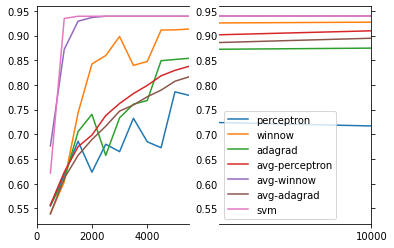

In [245]:

plot_learning_curves(perceptron_accs,
                        winnow_accs,
                        adagrad_accs,
                        avg_perceptron_accs,
                        avg_winnow_accs,
                        avg_adagrad_accs,
                        svm_accs
                        )

array([0.943 , 0.9445, 0.9445, 0.9445, 0.9445, 0.9445, 0.9445, 0.9445,
       0.9445, 0.9445, 0.9445])

In [157]:
def compute_accuracy_313(X_dev,y_dev,classifier):
    count = 0
    for i in range(len(X_dev)):
        x = X_dev[i]
        y = classifier.predict_single(x)
        if y_dev[i] == y:
            count += 1
    return (count/len(X_dev))

#### 3.1.3 Final Evaluation (5 points)

Finally, for each of the 7 models, train the models on all of the training data and compute the test accuracy.
For Winnow and Perceptron with AdaGrad, use the best hyperparameter settings you found.
Report these accuracies in a table.
   
We will run our models with [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000] examples.

In [ ]:
sample_sizes = [500 * i for i in range(1, 11)] + [10_000]

In [216]:
def run_synthetic_experiment(dataset_type='sparse'):
    """
    TODO: IMPLEMENT 
    
    Runs the synthetic experiment on either the sparse or dense data
    depending on the data path (e.g. "data/sparse" or "data/dense").
    
    We have provided how to train the Perceptron on the training and
    test on the testing data (the last part of the experiment). You need
    to implement the hyperparameter sweep, the learning curves, and
    predicting on the test dataset for the other models.
    """
    
    X_train, y_train, X_dev, y_dev, X_test, y_test, features = load_synthetic_data(dataset_type)
    

    # TODO: YOUR CODE HERE. Determine the best hyperparameters for the relevant models
    # report the validation accuracy after training using the best hyper parameters
    
#     i think i did all of these picked the best hyper parameters way above here near the hyper parameter tables
        
    
    # TOOD: YOUR CODE HERE. Downsample the dataset to the number of desired training
    # instances (e.g. 500, 1000), then train all of the models on the
    # sampled dataset. Compute the accuracy and add the accuracies to
    # the corresponding list. Use plot_learning_curves()
    
#     I did all of these near where the plot is, separated into 7 or 8 cells. please refer to that.
        
    
    # TODO: Train all 7 models on the training data and make predictions 
    # for test data
    # We will show you how to do it for the basic Perceptron model.
    classifier = Perceptron(features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Perceptron's accuracy is {acc}")

    # YOUR CODE HERE: Repeat for the other 6 models.

#     Averaged Perceptron
    classifier = AveragedPerceptron(features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Averaged Perceptron's accuracy is {acc}")
    
#     Winnow
    alpha = 1.01
    classifier = Winnow(alpha,features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Winnow's accuracy is {acc}")
    
#     Averaged Winnow
    alpha = 1.1
    classifier = AveragedWinnow(alpha,features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Averged Winnow's accuracy is {acc}")
    
#     Averaged Winnow
    eta = 1.5
    classifier = AdaGrad(eta,features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"AdaGrad's accuracy is {acc}")
    
#     Averaged Winnow
    eta = 1.5
    classifier = AveragedAdaGrad(eta,features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Averged AdaGrad's accuracy is {acc}")
    
    vectorizer = DictVectorizer()
    X_train_dict = vectorizer.fit_transform(X_train)
    X_test_dict = vectorizer.transform(X_test)
    classifier = LinearSVC(loss = 'hinge')
    classifier.fit(X_train_dict,y_train)
    acc = classifier.score(X_test_dict,y_test)
    print(f"SVM's accuracy is {acc}")

In [218]:
"""
Run the synthetic experiment on the sparse dataset. For reference,
"synthetic/sparse" is the path to where the data is located.
Note: This experiment takes substantial time (around 15 minutes),
so don't worry if it's taking a long time to finish.
"""
run_synthetic_experiment('sparse')

Perceptron's accuracy is 0.717
Averaged Perceptron's accuracy is 0.9135
Winnow's accuracy is 0.926
Averged Winnow's accuracy is 0.936
AdaGrad's accuracy is 0.878
Averged AdaGrad's accuracy is 0.884
SVM's accuracy is 0.936


In [217]:
"""
Run the synthetic experiment on the dense dataset. For reference,
"synthetic/dense" is the path to where the data is located.
Note: this experiment should take much less time.
"""
run_synthetic_experiment('dense')

Perceptron's accuracy is 0.9205
Averaged Perceptron's accuracy is 0.9405
Winnow's accuracy is 0.9255
Averged Winnow's accuracy is 0.9405
AdaGrad's accuracy is 0.9325
Averged AdaGrad's accuracy is 0.9405
SVM's accuracy is 0.9405


##### Questions (5 points)

Answer the following questions:

1. Discuss the trends that you see when comparing the standard version of an algorithm to the averaged version (e.g., Winnow versus Averaged Winnow). Is there an observable trend?
    
    Typically averaged version of the algorithm has a slightly higher accuracy than the standard version, only 0.01~0.02 improvement but quite consistent.


2. We provided you with 10,000 training examples.
   Were all 10,000 necessary to achieve the best performance for each classifier?
   If not, how many were necessary? (Rough estimates, no exact numbers required)
   
   Not all were necessary. Looking at the learning rate graph, accuracy for both dense and sparse datasets plateau around 6000-7000 training examples for even the worst-performing algorithm. For the best-performing algorithm, SVM, it converge to the highest accuracy with only about 1000 training examples. Further examples did not provide any improvement over accuracy.


3. Report your Final Test Accuracies

   

| Model               | Sparse | Dense |
|---------------------|--------|-------|
| Perceptron          |  0.7170      |   0.9205    |
| Winnow              |  0.9260      |  0.9255     |
| AdaGrad             |  0.8780      |  0.9325     |
| Averaged Perceptron |  0.9135      |  0.9405     |
| Averaged Winnow     |  0.9360      |  0.9405     |
| Averaged AdaGrad    |  0.8840      |  0.9405     |
| SVM                 |  0.9360      |  0.9405     |
   
  

#### 3.1.5 Extra Credit (10 points)

Included in the resources for this homework assignment is the code that we used to generate the synthetic data.
We used a small amount of noise to create the dataset which you ran the experiments on.
For extra credit, vary the amount of noise in either/both of the label and features.
Then, plot the models' performances as a function of the amount of noise.
Discuss your observations.

TODO: Extra Credit observations

In [261]:
X_train, y_train, X_dev, y_dev, X_test, y_test, features = load_synthetic_data('dense')
noise = np.linspace(0,1,21)
ec_winnowacc = np.zeros(len(noise))
ec_perceptronacc = np.zeros(len(noise))
ec_adagradacc = np.zeros(len(noise))
ec_svmacc = np.zeros(len(noise))

for i in range(len(noise)):
    X_train, y_train, X_dev, y_dev, X_test, y_test, features = load_synthetic_data('dense')
    classifier = Perceptron(features)
    num = int(len(y_train) * noise[i])
    for j in range(num):
        tempRand = np.random.randint(0,len(y_train))
        y_train[tempRand] = -y_train[tempRand]
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    ec_perceptronacc[i] = accuracy_score(y_test, y_pred)

for i in range(len(noise)):
    X_train, y_train, X_dev, y_dev, X_test, y_test, features = load_synthetic_data('dense')
    classifier = Winnow(1.1,features)
    num = int(len(y_train) * noise[i])
    for j in range(num):
        tempRand = np.random.randint(0,len(y_train))
        y_train[tempRand] = -y_train[tempRand]
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    ec_winnowacc[i] = accuracy_score(y_test, y_pred)

for i in range(len(noise)):
    X_train, y_train, X_dev, y_dev, X_test, y_test, features = load_synthetic_data('dense')
    classifier = AdaGrad(1.5,features)
    num = int(len(y_train) * noise[i])
    for j in range(num):
        tempRand = np.random.randint(0,len(y_train))
        y_train[tempRand] = -y_train[tempRand]
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    ec_adagradacc[i] = accuracy_score(y_test, y_pred)
    
for i in range(len(noise)):
    X_train, y_train, X_dev, y_dev, X_test, y_test, features = load_synthetic_data('dense')
    num = int(len(y_train) * noise[i])
    for j in range(num):
        tempRand = np.random.randint(0,len(y_train))
        y_train[tempRand] = -y_train[tempRand]
    vectorizer = DictVectorizer()
    X_train_dict = vectorizer.fit_transform(X_train)
    X_test_dict = vectorizer.transform(X_test)
    classifier = LinearSVC(loss = 'hinge')
    classifier.fit(X_train_dict,y_train)
    ec_svmacc[i] = classifier.score(X_test_dict,y_test)

In [264]:
plot_EC_curves(ec_perceptronacc,ec_winnowacc,ec_adagradacc,ec_svmacc)

NameError: name 'ax' is not defined

<Figure size 432x288 with 0 Axes>

In [263]:
"""
A helper function that plots the relationship between number of examples
and accuracies for all the models.

You should not need to edit this method.
"""
def plot_EC_curves(
    perceptron_accs,
    winnow_accs,
    adagrad_accs,
    svm_accs
):
    
    accuracies = [
        ('perceptron', perceptron_accs),
        ('winnow', winnow_accs),
        ('adagrad', adagrad_accs),
        ('svm', svm_accs)
    ]
    
    x = np.linspace(0,1,21)
    plt.figure()
#     f, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w')
    
    for label, acc_list in accuracies:
        assert len(acc_list) == 21
        ax.plot(x, acc_list, label=label)
#         ax2.plot(x, acc_list, label=label)
        
    ax.set_xlim(0, 1)
#     ax2.set_xlim(9500, 10000)
#     ax2.set_xticks([10000])
    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
#     ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax.tick_params(labelright='off')
    ax2.yaxis.tick_right()
    ax2.legend()
    plt.show()

In [259]:
ec_winnowacc

array([0.814 , 0.802 , 0.718 , 0.784 , 0.6285, 0.7525, 0.769 , 0.6545,
       0.5415, 0.6905, 0.707 , 0.6945, 0.688 , 0.718 , 0.656 , 0.7205,
       0.725 , 0.6525, 0.77  , 0.7515, 0.812 ])

### 3.2 NER Experiment: Welcome to the Real World (35 points)

The experiment with the NER data will analyze how changing the domain of the training and testing data can impact the performance of a model.

Instead of accuracy, you will use your $F_1$ score implementation in Section 0 to evaluate how well a model does.
Recall measures how many of the actual entities the model successfully tagged as an entity.

$$
\begin{align}
    \textrm{Precision} &= \frac{\#\textrm{(Actually Entity & Model Predicted Entity)}}{\#\textrm{(Model Predicted Entity)}} \\
    \textrm{Recall} &= \frac{\#\textrm{(Actually Entity & Model Predicted Entity)}}{\#\textrm{(Actually Entity)}} \\
    \textrm{F}_1 &= 2 \cdot \frac{\textrm{Precision} \times \textrm{Recall}}{\textrm{Precision} + \textrm{Recall}}
\end{align}
$$

For this experiment, you will only use the averaged basic Perceptron and SVM.
Hence, no parameter tuning is necessary.
Train both models on the CoNLL training data then compute the F$_1$ on the development and testing data of both CoNLL and Enron.
Note that the model which is used to predict labels for Enron is trained on CoNLL data, not Enron data.
Report the F$_1$ scores in a table.

#### 3.2.1 Extracting NER Features  (25 points)

Reread Section 2.2.2 to understand how to extract the features required to train the models
and translate it to the code below.

In [276]:
def extract_ner_features_train(train):
    """
    Extracts feature dictionaries and labels from the data in "train"
    Additionally creates a list of all of the features which were created.
    We have implemented the w-1 and w+1 features for you to show you how
    to create them.
    
    TODO: You should add your additional featurization code here.
    (which might require adding and/or changing existing code)
    """
    y = []
    X = []
    features = set()
    for sentence in train:
        padded = [('SSS', None)] + [('SSS', None)] + [('SSS', None)] + sentence[:]\
                    + [('EEE', None)] + [('EEE', None)] + [('EEE', None)]
        for i in range(3, len(padded) - 3):
            y.append(1 if padded[i][1] == 'I' else -1)
            feat1 = 'w-1=' + str(padded[i - 1][0])
            feat2 = 'w+1=' + str(padded[i + 1][0])
            feat3 = 'w-3=' + str(padded[i - 3][0])
            feat4 = 'w-2=' + str(padded[i - 2][0])
            feat5 = 'w+2=' + str(padded[i + 2][0])
            feat6 = 'w+3=' + str(padded[i + 3][0])
            feat7 = 'w-1&w-2=' + str(padded[i - 1][0] + str(padded[i - 2][0]))
            feat8 = 'w+1&w+2=' + str(padded[i + 1][0] + str(padded[i + 2][0]))
            feat9 = 'w-1&w+1=' + str(padded[i - 1][0] + str(padded[i + 1][0]))
            feats = [feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8, feat9]
            features.update(feats)
            feats = {feature: 1 for feature in feats}
            X.append(feats)
    return features, X, y

Now, repeat the process of extracting features from the test data.
What is the difference between the code above and below?

In [275]:
def extract_features_dev_or_test(data, features):
    """
    Extracts feature dictionaries and labels from "data". The only
    features which should be computed are those in "features". You
    should add your additional featurization code here.
    
    TODO: You should add your additional featurization code here.
    """
    y = []
    X = []
    for sentence in data:
        padded = [('SSS', None)] + [('SSS', None)] + [('SSS', None)] + sentence[:]\
                    + [('EEE', None)] + [('EEE', None)] + [('EEE', None)]
        for i in range(3, len(padded) - 3):
            y.append(1 if padded[i][1] == 'I' else -1)
            feat1 = 'w-1=' + str(padded[i - 1][0])
            feat2 = 'w+1=' + str(padded[i + 1][0])
            feat3 = 'w-3=' + str(padded[i - 3][0])
            feat4 = 'w-2=' + str(padded[i - 2][0])
            feat5 = 'w+2=' + str(padded[i + 2][0])
            feat6 = 'w+3=' + str(padded[i + 3][0])
            feat7 = 'w-1&w-2=' + str(padded[i - 1][0] + str(padded[i - 2][0]))
            feat8 = 'w+1&w+2=' + str(padded[i + 1][0] + str(padded[i + 2][0]))
            feat9 = 'w-1&w+1=' + str(padded[i - 1][0] + str(padded[i + 1][0]))
            feats = [feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8, feat9]
#             feats = [feat1, feat2]
            feats = {feature: 1 for feature in feats if feature in features}
            X.append(feats)
    return X, y

#### 3.2.2 Running the NER Experiment

As stated previously, train both models on the CoNLL training data then compute the $F_1$  on the development and testing data of both CoNLL and Enron. Note that the model which is used to predict labels for Enron is trained on CoNLL data, not Enron data.

In [282]:
def run_ner_experiment(data_path):
    """
    Runs the NER experiment using the path to the ner data
    (e.g. "ner" from the released resources). We have implemented
    the standard Perceptron below. You should do the same for
    the averaged version and the SVM.
    
    The SVM requires transforming the features into a different
    format. See the end of this function for how to do that.
    """
    train = load_ner_data(dataset='conll', dataset_type='train')
    conll_test = load_ner_data(dataset='conll', dataset_type='test')
    enron_test = load_ner_data(dataset='enron', dataset_type='test')

    features, X_train, y_train = extract_ner_features_train(train)
    X_conll_test, y_conll_test = extract_features_dev_or_test(conll_test, features)
    X_enron_test, y_enron_test = extract_features_dev_or_test(enron_test, features)
                 
    # TODO: We show you how to do this for Perceptron.
    # You should do this for the Averaged Perceptron and SVM
    classifier = Perceptron(features)
    classifier.train(X_train, y_train)
    
    y_pred = classifier.predict(X_conll_test)
    conll_f1 = calculate_f1(y_conll_test, y_pred)

    y_pred = classifier.predict(X_enron_test)
    enron_f1 = calculate_f1(y_enron_test, y_pred)
    print('Perceptron on NER')
    print('  CoNLL', conll_f1)
    print('  Enron', enron_f1)
    
    
#     Averaged Perceptron
#     classifier = AveragedPerceptron(features)
#     classifier.train(X_train, y_train)
    
#     y_pred = classifier.predict(X_conll_test)
#     conll_f1 = calculate_f1(y_conll_test, y_pred)

#     y_pred = classifier.predict(X_enron_test)
#     enron_f1 = calculate_f1(y_enron_test, y_pred)
#     print('Averaged Perceptron on NER')
#     print('  CoNLL', conll_f1)
#     print('  Enron', enron_f1)
    
    
#     SVM
    # This is how you convert from the way we represent features in the
    # Perceptron code to how you need to represent features for the SVM.
    # You can then train with (X_train_dict, y_train) and test with
    # (X_conll_test_dict, y_conll_test) and (X_enron_test_dict, y_enron_test)
    vectorizer = DictVectorizer()
    X_train_dict = vectorizer.fit_transform(X_train)
    X_conll_test_dict = vectorizer.transform(X_conll_test)
    X_enron_test_dict = vectorizer.transform(X_enron_test)
    classifier = LinearSVC(loss = 'hinge')
    classifier.fit(X_train_dict,y_train)
    
    y_pred = classifier.predict(X_conll_test_dict)
    conll_f1 = calculate_f1(y_conll_test,y_pred)
    
    y_pred = classifier.predict(X_enron_test_dict)
    enron_f1 = calculate_f1(y_enron_test, y_pred)
    print('Averaged Perceptron on NER')
    print('  CoNLL', conll_f1)
    print('  Enron', enron_f1)

In [283]:
# Run the NER experiment. "ner" is the path to where the data is located.
run_ner_experiment('ner')

Perceptron on NER
  CoNLL 0.7443890274314214
  Enron 0.20623229461756373
Averaged Perceptron on NER
  CoNLL 0.827823691460055
  Enron 0.24119530416221988



##### F1 Scores Table 
TODO: report your values:  

| Model               | CoNLL Test F1 | Enron Test F1 |
|---------------------|---------------|---------------|
| Averaged Perceptron |               |               |
| SVM                 |   0.8278            |    0.2412           |

##### Questions (5 points)

Comment on the results:
1. Are the F$_1$ scores on CoNLL and Enron similar?
    
    No, F$_1$ scores on CoNLL and Enron are quite different. CoNLL has much higher ones than Enron.
    

2. If they are dissimilar, explain why you think the F$_1$ score increased/decreased on the Enron data.

    CoNLL has both training and testing data so the classifiers are more fitted towards that type of data. Enron is a brand new group of examples that are unrelated to CoNLL so classifiers might have trouble identify it. This could be a sign of overfitting.


## Submission Instructions

We will be using Gradescope to turn in both the Python code.
You should have been automatically added to Gradescope.
If you do not have access, please ask the TA staff on Piazza.

There are three parts to the submission on Gradescope:
* ipynb file: Submit this notebook (.ipynb). If you are using Google Colab, you will have to download it as an ipynb file.
* PDF: This notebook saved as a PDF. We will use this to see the overall structure of your homework and code, and to check manual questions like the tables, plots, and your discussions. How should I convert this notebook to PDF, you may ask? There are a few ways, but for simplicity print the Jupyter notebook and _Save as PDF_.
* Code: A `hw2.py` file. We will use this to unit test and automate grading some parts of the homework. We only need a few functions/classes from the whole notebook. In particular, to unit test we only need:
    - `calculate_f1`
    - `highest_and_lowest_f1_score`
    - `Perceptron`, `Winnow`, and `AdaGrad` classes.
    
There are two ways to submit these pieces of code. You can either manually copy and paste these to a Python file,
or you can use Jupyter's _Download as .py_, and delete all unnecessary code. 